<h1><center> <ins><b>Full Example of our Modern Portfolio Theory Code</b></ins> </center></h1>

<h2> <b><ins>Aims</ins></b></h2>

Having explained the fundamental ideas and code behind MPT in our previous notebook, I seek to provide a full example to show how to:

- Calculate expected returns via CAPM and covariances via Ledoit-Wolf Shrinkage Estimator
- Plot the covariance and correlation matrices via a heatmap
- Calculate the optimal weights for each asset for various strategies
- Visualise our Efficient Frontier with random portfolios, Capital Market Line and the points on our Frontier that are the above said optimal weights
- Find the optimal allocation of shares for each asset given a set of weights
- Plot the weights and allocation of each strategy via a grouped bar plot
- Produce a set of results that conclude what we have achieved

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import portfolio_params as params
import portfolio_optimisers as opt
import allocations as alloc
import plotting as plot
import results as results
from Individual_Functions import price_data, returns_data
import warnings
import re

In [2]:
# CvxPy gives us a warning when a solution may be inaccurate, we will ignore this message but this block can be deleted if one wants to keep the message
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        message=re.escape("Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.")
                       )

In [3]:
# Get list of S&P500 stocks from wikipedia
temp = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
temp['Symbol'] = temp['Symbol'].str.replace('.', '-')
stocks = temp['Symbol'].unique().tolist()

# Specify start and end dates
start_date = '2018-01-01'
end_date = '2025-03-01'

# Get price data for all stocks and then drop those we do not have a full historical price data for
full_df = price_data(stocks,start_date,end_date)
valid_tickers = full_df.dropna(axis=1).columns.tolist()

# Check we have at least 100 valid tickers
if len(valid_tickers) >= 100:
    # Randomly sample 100 from valid tickers
    np.random.seed(0)
    chosen_tickers = sorted(np.random.choice(valid_tickers, size=100, replace=False))
    df = full_df[chosen_tickers]
else:
    raise ValueError(f"Only {len(valid_tickers)} tickers have full data — not enough for 100.")

# Call return function
ret_df = returns_data(df)

[*********************100%***********************]  503 of 503 completed


In [4]:
# Calculate expected returns, covariance and correlation matrices using our Parameters class

parameters = params.parameters(ret_df, frequency=252, risk_free_rate=0.041)
mu = parameters.expected_returns_capm()
cov,cov_df = parameters.covariance_matrix_ledoit_wolf()
corr_df = parameters.correlation_matrix()

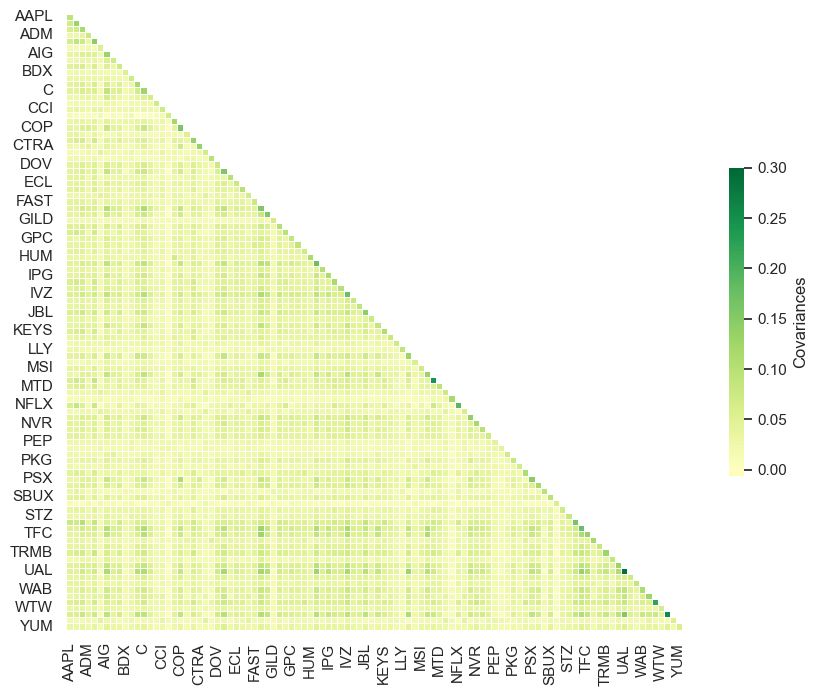

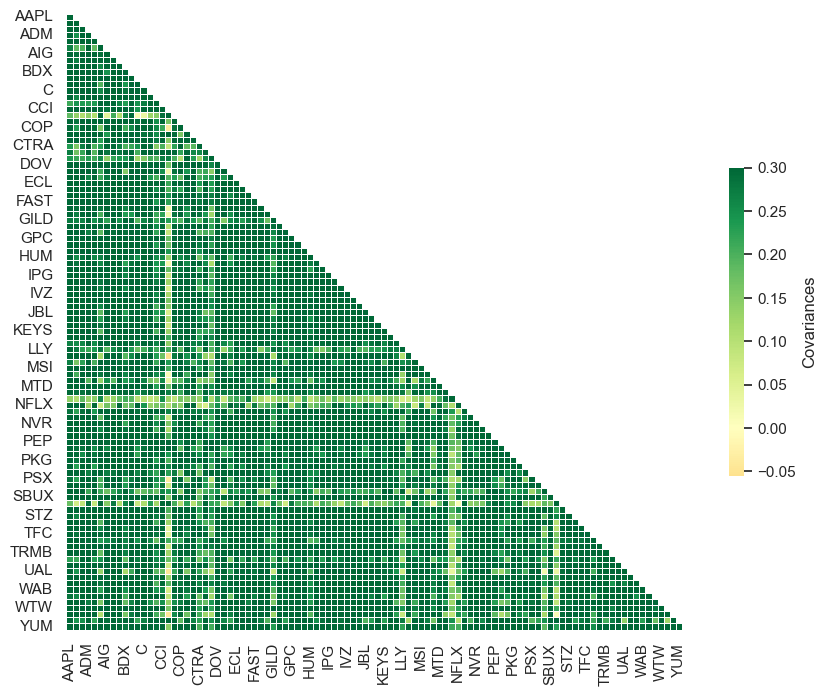

In [5]:
# Plot our covariance and correlation matrices as heatmaps

plot.heatmap(cov_df)
plot.heatmap(corr_df)

In [6]:
# Calculate the optimal weights for a given strategy

opts = opt.optimisers(mu, cov, weight_bounds=[-1,1])
ret_maxret, risk_maxret, weights_maxret = opts.maximise_return()
ret_minrisk, risk_minrisk, weights_minrisk = opts.minimise_risk(target_return = 0)
ret_maxsr, risk_maxsr, weights_maxsr = opts.maximise_sharpe_ratio(risk_free_rate=0.046)

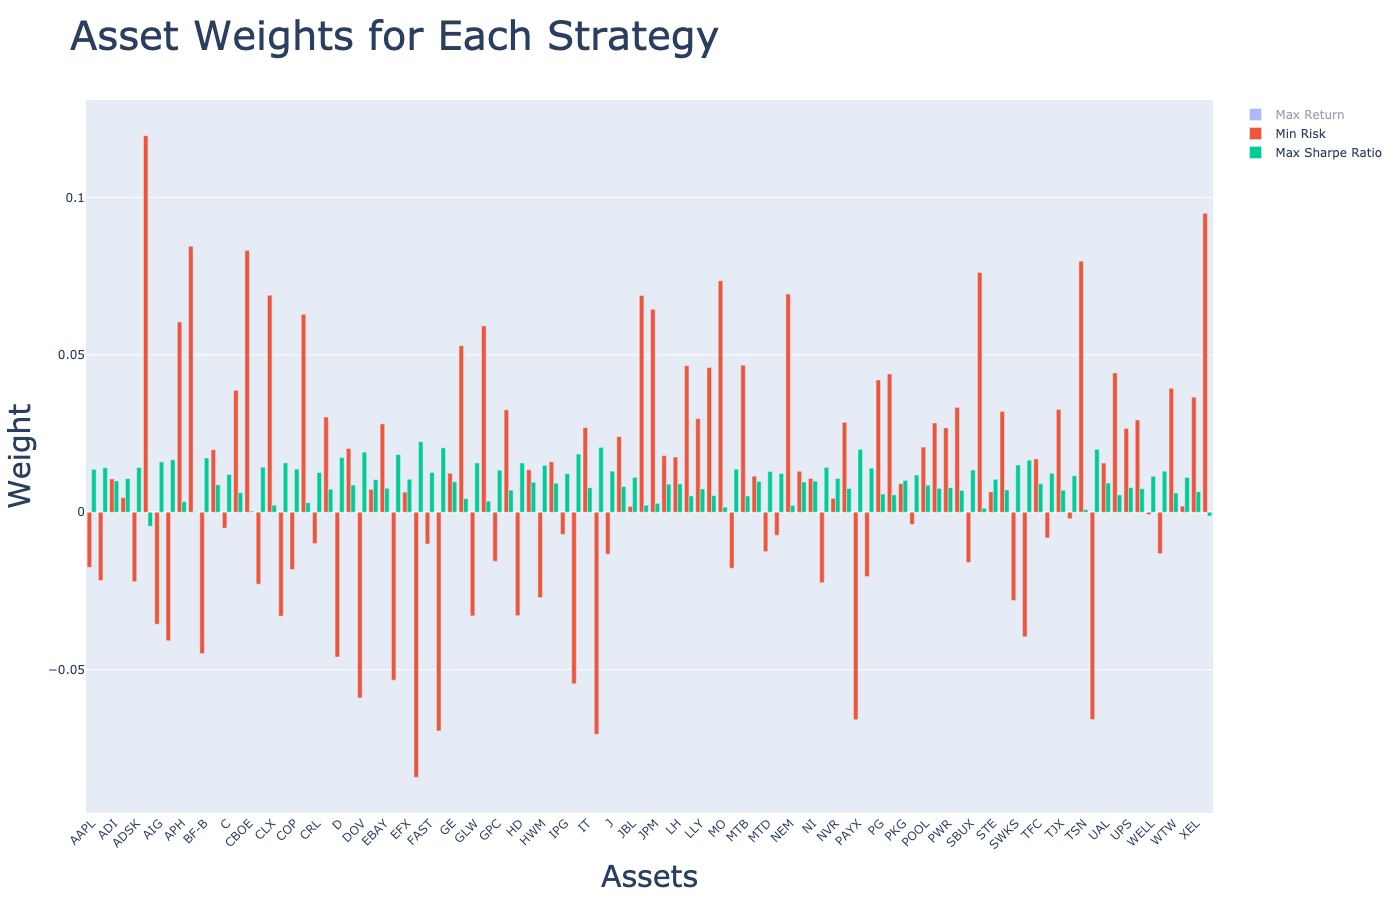

In [7]:
# Plot these weights

weights_plot = plot.weights(mu, cov, weight_bounds=[-1,1], risk_free_rate=0.046)
# Write plot to html so we can interact with it but still view the image as a static png so it displays on github
# Remove renderer condition if you would like to view interactive plot on this notebook
weights_plot.write_html("Weights_Plot.html")
weights_plot.show(renderer="png")

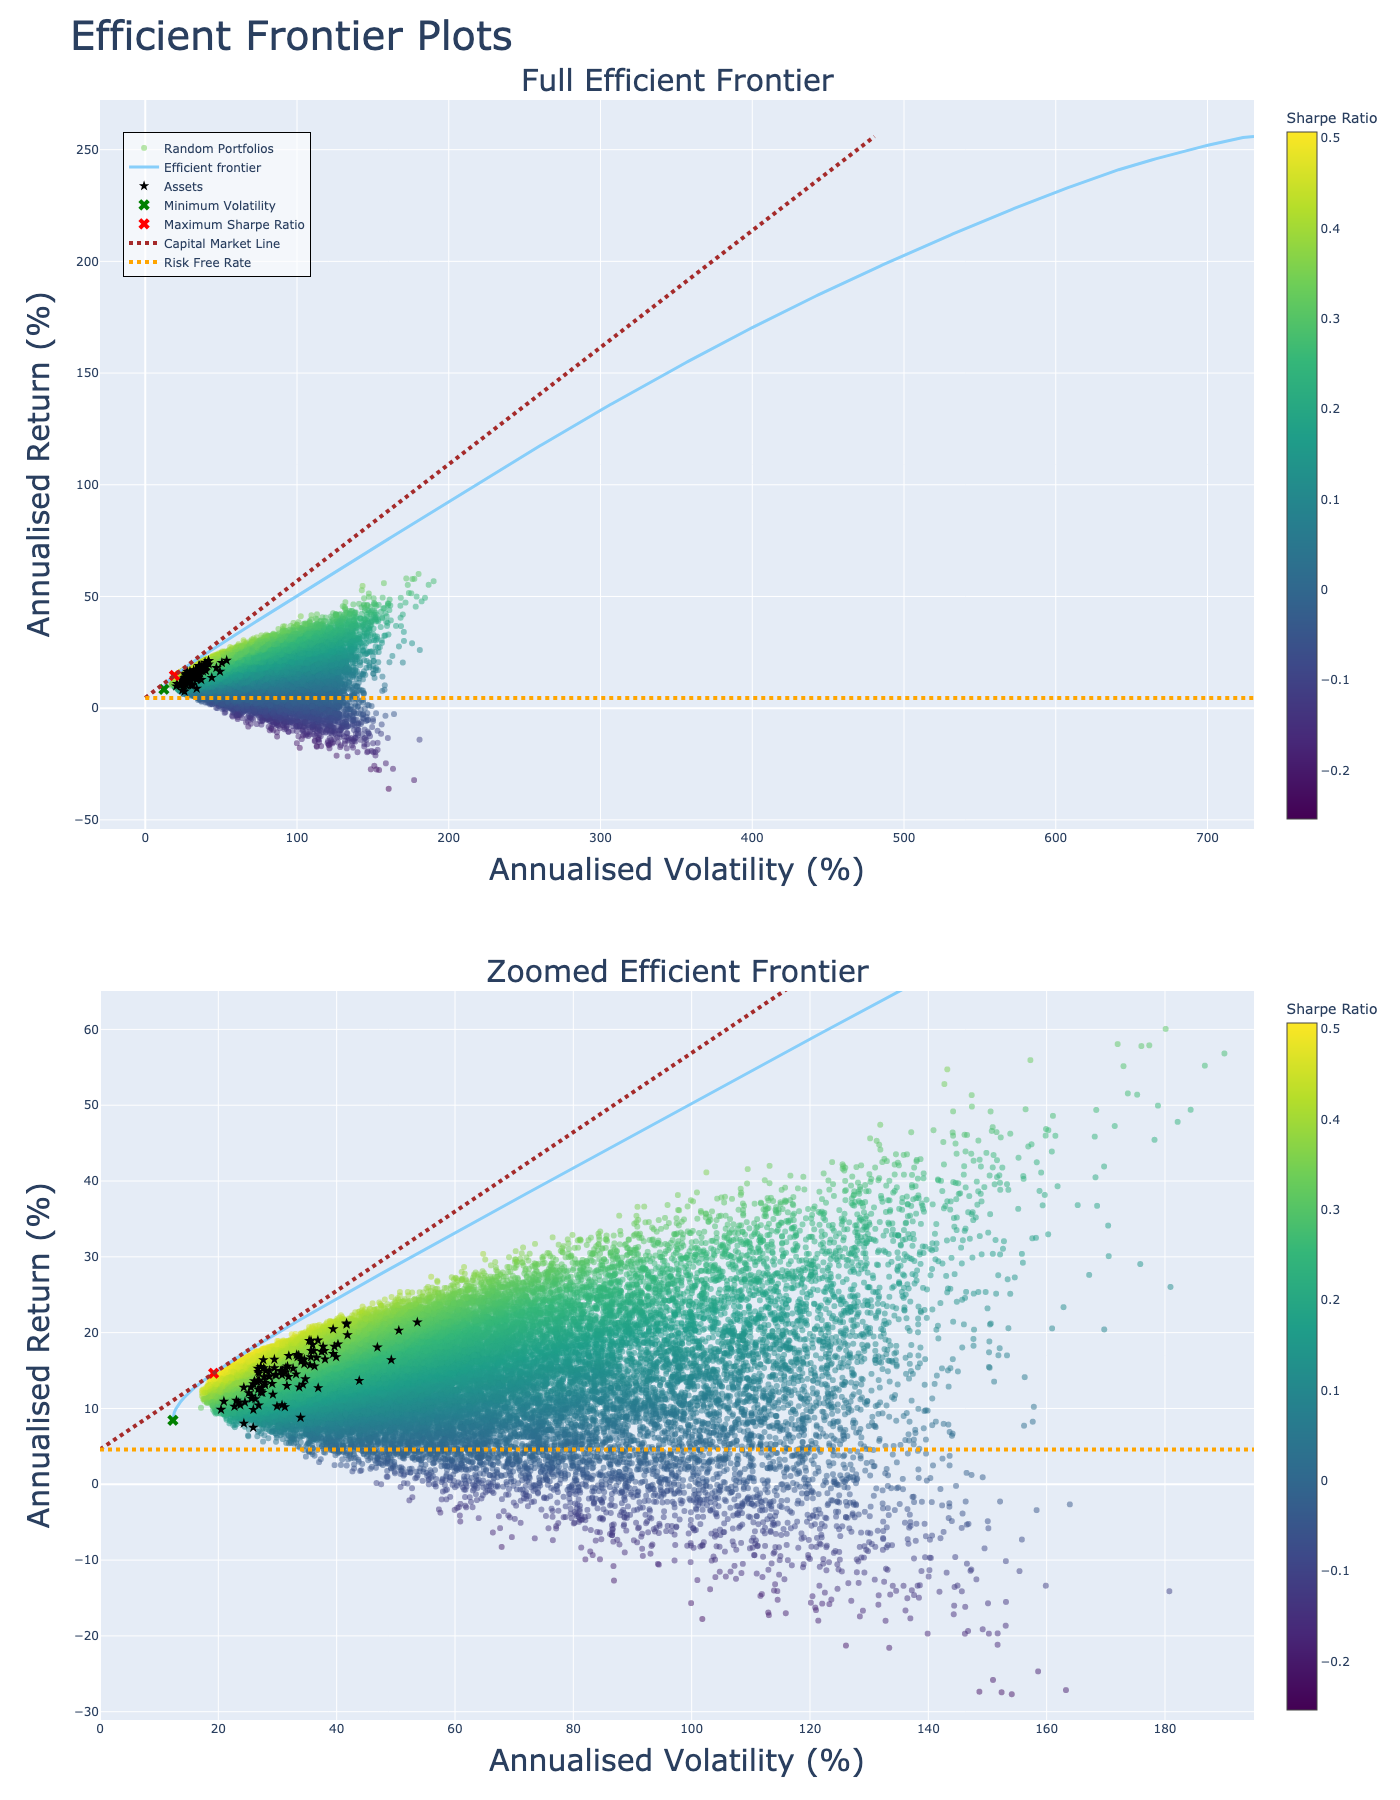

In [8]:
# Plot Efficient Frontier

ef_plot = plot.efficient_frontier(mu, cov, risk_free_rate=0.046, weight_bounds=[-1,1])
# Write plot to html so we can interact with it but still view the image as a static png so it displays on github
# Remove renderer condition if you would like to view interactive plot on this notebook
ef_plot.write_html("EfficientFrontier_Plot.html")
ef_plot.show(renderer="png")

In [9]:
# Find the optimal allocation and leftover amount for a given strategy

allocation, leftover = alloc.allocation(df.iloc[-1], weights_maxsr, total_investment=10_000, short_ratio=0.2, reinvest=False, remove_zero_investments=False)

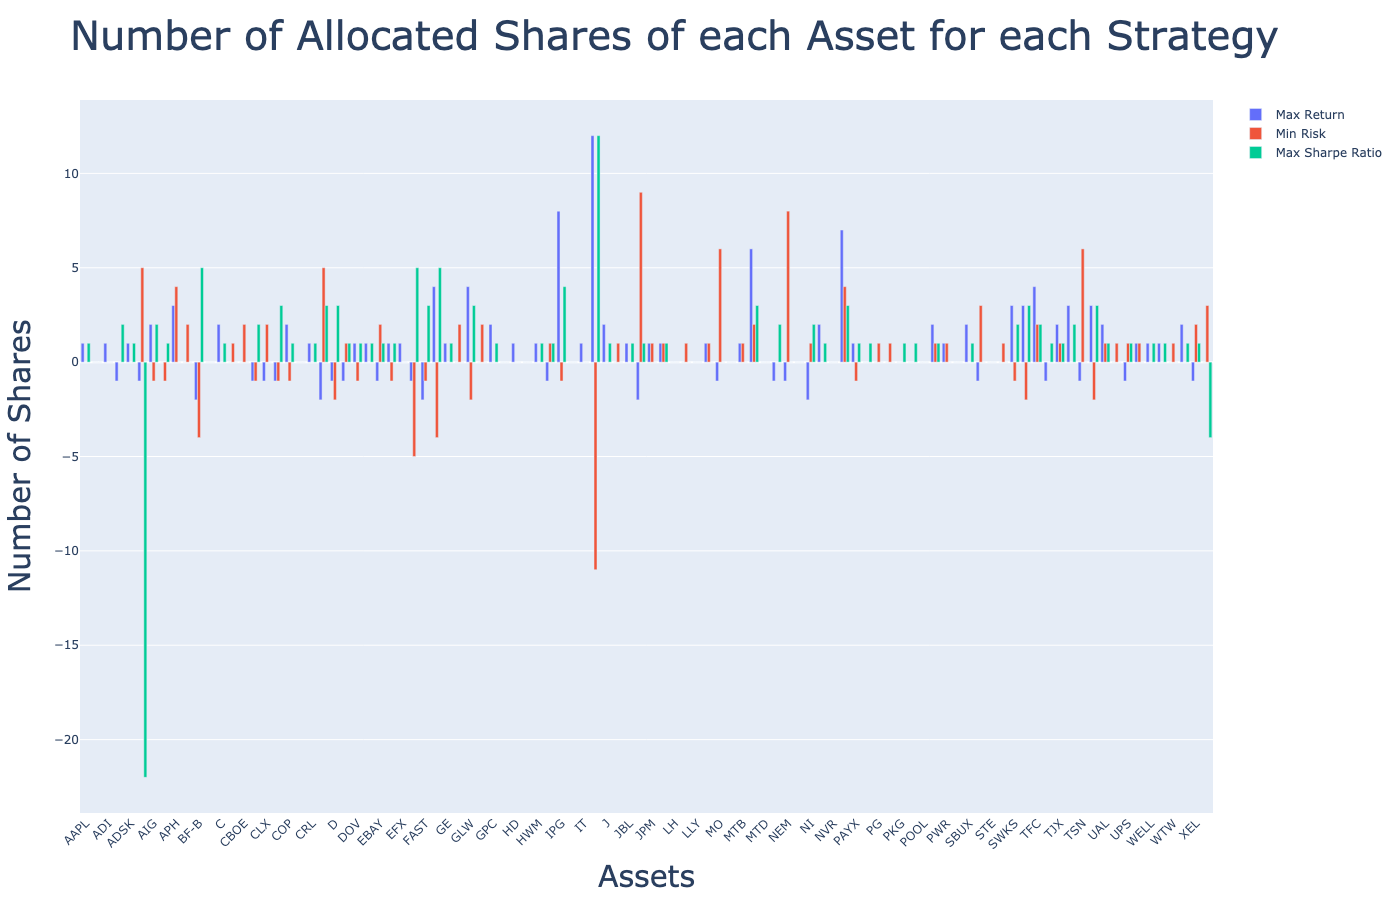

In [10]:
# Plot the allocations of strategies

alloc_plot = plot.allocations(df, mu, cov, weight_bounds=[-1,1], risk_free_rate=0.046, total_investment=10_000)
# Write plot to html so we can interact with it but still view the image as a static png so it displays on github
# Remove renderer condition if you would like to view interactive plot on this notebook
alloc_plot.write_html("Allocations_Plot.html")
alloc_plot.show(renderer="png")

In [11]:
# Full results of everything

metrics, distributions, leftovers = results.full_results(df, mu, cov, weight_bounds=[-1,1], risk_free_rate=0.046, total_investment=10_000, short_ratio=0.2, results=True)

                  Return (%)  Volatility (%)  Sharpe Ratio
Strategy                                                  
Max Return        255.912491      730.635503      0.343964
Min Risk            8.438741       12.319334      0.311603
Max Sharpe Ratio   15.450830       20.712109      0.523888
                          Weights  Allocations
Strategy         Ticker                       
Max Return       AAPL    1.000000            1
                 ADBE    1.000000            0
                 ADI     1.000000            1
                 ADM    -1.000000           -1
                 ADSK    1.000000            1
...                           ...          ...
Max Sharpe Ratio WSM     0.013047            1
                 WTW     0.006128            0
                 WYNN    0.011063            1
                 XEL     0.006502            1
                 YUM    -0.001194           -3

[300 rows x 2 columns]
                  Leftover Amount
Strategy                         
Ma